# All final plots and analyses for figure 1

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings('ignore')
import joblib
import matplotlib.colors as mcolors

### Functions for plots from GrooD

### Figure 1A - CT metrics for pseudobulk framework (Hao dataset)

In [2]:
pred = pd.read_csv('/ceph/ibmi/it/projects/ML_BI/16_GrooD/GrooD/grood_runs/GrooD_Hao_pseudobulk_new/intersect_CPM/inference/MasterTable.csv', index_col=0)
pred.head()

,B cells,CD4 T cells,CD8 T cells,DC,Monocytes,NK cells,Tregs,Pred B cells,Pred CD4 T cells,Pred CD8 T cells,Pred DC,Pred Monocytes,Pred NK cells,Pred Tregs,SampleID,error
Sample_1,0.072435,0.354125,0.012072,0.317907,0.225352,0.000000,0.018109,0.078520,0.334190,0.008480,0.311386,0.208672,0.006637,0.019424,Sample_1,-0.001316
Sample_2,0.269076,0.198795,0.028112,0.036145,0.283133,0.158635,0.026104,0.273829,0.170196,0.028150,0.038992,0.283216,0.175564,0.030053,Sample_2,-0.003949
Sample_3,0.032193,0.464789,0.022133,0.000000,0.175050,0.295775,0.010060,0.032592,0.439337,0.019437,0.003109,0.178013,0.309697,0.017816,Sample_3,-0.007756
Sample_4,0.000000,0.042254,0.016097,0.472837,0.434608,0.020121,0.014085,0.006329,0.042651,0.019074,0.459967,0.428210,0.019802,0.019810,Sample_4,-0.005726
Sample_5,0.610442,0.253012,0.002008,0.042169,0.066265,0.000000,0.026104,0.597042,0.278658,0.003613,0.050729,0.046209,0.005899,0.017849,Sample_5,0.008256


In [3]:
# Correlation analysis

def getCorr(df, cellTypes):

    """
    Computes correlation and error metrics for predicitions vs. ground-truth as stored in the MasterTable
    df: MasterTable of samples x cell types (predicted proportions with prefix 'Pred ', groundtruth only with cell type name)
    cellTypes: basically list of cell types as in groundtruth
    """


    rsquared = []
    cccs = []
    rmses = []
    spearmans = []
    percent_dev = []
    absol_dev = []

    # Concordance correlation coefficient
    def ccc(x_data,y_data):
        sxy = np.sum((x_data - np.mean(x_data))*(y_data - np.mean(y_data)))/len(x_data)
        rhoc = 2*sxy / (np.var(x_data) + np.var(y_data) + (np.mean(x_data) - np.mean(y_data))**2)
        return rhoc


    # Pearson Correlation Coefficient
    def r(x_data,y_data):
        ''' Pearson Correlation Coefficient'''
        sxy = np.sum((x_data - np.mean(x_data))*(y_data - np.mean(y_data)))/len(x_data)
        rho = sxy / (np.std(x_data)*np.std(y_data))
        return rho


    # RMSE
    def rmse(x_data,y_data):
        MSE = np.mean(np.square((np.array(x_data)-np.array(y_data))))
        RMSE = np.sqrt(MSE)
        return RMSE

    # Spearmans rank correlation    
    def spearman(x_data, y_data):
        spearmanCorr, _ = stats.spearmanr(np.array(x_data), np.array(y_data))
        return spearmanCorr
    
    # Percent deviation function
    def frac_deviation(x_data, y_data):
        frac_devs = np.mean(np.divide((np.array(y_data) - np.array(x_data)),np.array(x_data), where=(np.array(x_data)!=0)))
        return frac_devs # for sparse data, quite some data points might be excluded due to the removal of 0-divisions from the mean
    
    # Absolute deviation function
    def abs_deviation(x_data, y_data):
        abs_devs = np.mean(abs(np.array(y_data) - np.array(x_data)))
        return abs_devs


    for cell in cellTypes:
        groundTruth = cell
        pred = 'Pred ' + cell
        
        xdata = df[groundTruth].tolist()
        ydata = df[pred].tolist()
        b = r(xdata, ydata)
        rsquared.append(b)
        c = ccc(xdata, ydata)
        cccs.append(c)
        a = rmse(xdata, ydata)
        rmses.append(a)
        g = abs_deviation(xdata, ydata)
        absol_dev.append(g)


        #print('R: ', str(b), ' for ', cell)
        #print('CCC: ', str(c), ' for ', cell)
        #print('SpearmanR: ', str(s), ' for ', cell)
        #print('RMSE: ', str(a), ' for ', cell)
        #print('Mean percent deviation: ', str(f), ' for ', cell)
        #print('Mean absolute deviation: ', str(g), ' for ', cell)

    DF = pd.concat([pd.Series(rsquared), pd.Series(cccs), pd.Series(rmses), pd.Series(absol_dev)], axis = 1, ignore_index = True)
    DF.columns = ['PCC', 'CCC', 'RMSE', 'MAD']
    DF.index = cellTypes

    return DF

corr_res = getCorr(pred, ['B cells', 'CD4 T cells',	'CD8 T cells', 'DC', 'Monocytes', 'NK cells', 'Tregs'])
corr_res

,PCC,CCC,RMSE,MAD
B cells,0.998085,0.997936,0.010356,0.007773
CD4 T cells,0.988018,0.984774,0.027492,0.022047
CD8 T cells,0.993644,0.992950,0.009899,0.006670
DC,0.998703,0.998607,0.008629,0.006577
Monocytes,0.996832,0.995896,0.012543,0.009541
NK cells,0.996704,0.996241,0.012970,0.009832
Tregs,0.989908,0.972701,0.022560,0.014142


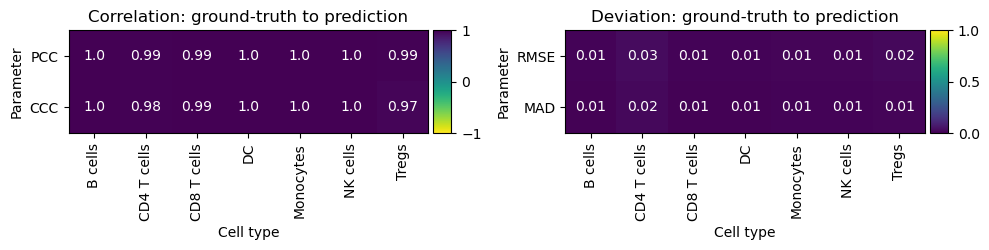

In [7]:
# Changed function for annotated heatmap

def annotated_heatmap(df):

    """"
    Visualizes correlation and error metrics computed with getCorr in heatmaps with fixed scales
    df: output from getCorr
    """

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    df1 = df.loc[['PCC', 'CCC']] # data for SCC, PCC, CCC
    df2 = df.loc[['RMSE', 'MAD']] # data for RMSE and percent deviation

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    im1 = ax1.imshow(df1, vmin=-1, vmax=1, cmap='viridis_r')

    for i in range(df1.shape[0]):
        for j in range(df1.shape[1]): 
            ax1.annotate(str(round(df1.iloc[i,j], 2)), xy=(j, i), 
                        ha='center', va='center', color='white')

    ax1.set_title('Correlation: ground-truth to prediction')
    ax1.set_xlabel('Cell type')
    ax1.set_ylabel('Parameter')
    ax1.set_yticks(range(df1.shape[0]), df1.index.tolist())
    ax1.set_xticks(range(df1.shape[1]), df1.columns.tolist(), rotation = 'vertical')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im1, cax = cax, ax = ax1)

    # vir = plt.get_cmap("viridis")
    # cmap_bt = mcolors.LinearSegmentedColormap.from_list(
    #     "viridis_bt", vir(np.linspace(0.0, 0.5, 256))
    # )

    im2 = ax2.imshow(df2, vmin=0, vmax=1, cmap="viridis")

    for i in range(df2.shape[0]):
        for j in range(df2.shape[1]): 
            ax2.annotate(str(round(df2.iloc[i,j], 2)), xy=(j, i), 
                        ha='center', va='center', color='white')

    ax2.set_title('Deviation: ground-truth to prediction')
    ax2.set_xlabel('Cell type')
    ax2.set_ylabel('Parameter')
    ax2.set_yticks(range(df2.shape[0]), df2.index.tolist())
    ax2.set_xticks(range(df2.shape[1]), df2.columns.tolist(), rotation = 'vertical')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im2, cax = cax, ax = ax2)

    plt.tight_layout()
    plt.savefig('Figure_1A.svg', transparent = True, dpi = 300, format = 'svg')
    plt.show()

annotated_heatmap(corr_res.transpose())

### SI Fig 1A

In [10]:
# Get convolution results using Hao and Finotello data account for cell type proportions
eval_res = pd.read_csv('Convolution/Hao-2_notarget_pseudobulks_Hao_2_train_metrics.csv', index_col=0)
#eval_res = eval_res.loc[eval_res['filter_strategy'] == 'none']
eval_res = eval_res.loc[eval_res['space'] == 'CPM']
eval_res = eval_res.loc[eval_res['metric'].isin(['Pearson', 'CCC', '1-JSD'])]
eval_res.replace({'none' : 'all', 'mRNA' : 'coding only'}, inplace=True)
eval_res.head()

,filter_strategy,space,metric,value
0,all,CPM,1-JSD,0.945361
1,all,CPM,Pearson,0.998448
3,all,CPM,CCC,0.998347
8,all,CPM,1-JSD,0.960648
9,all,CPM,Pearson,0.999712


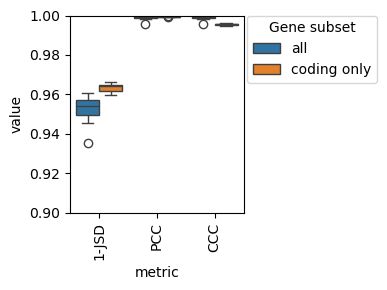

In [11]:
# Plot to visualize distribution of quality metrics

def boxplot_metrics(df):

    """
    Creates boxplot of proportions per cell type across samples in pred
    pred: samples x cell types pandas dataframe
    output: target directory
    """
    plt.figure(figsize=(4,3))
    p = sns.boxplot(data=df, x = "metric", y = "value", hue = "filter_strategy")
    p.set_xticklabels(p.get_xticklabels(), rotation=90)
    p.set_ylim([0.9,1])
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title = 'Gene subset')
    plt.xticks(np.arange(3), ['1-JSD', 'PCC', 'CCC'])
    plt.tight_layout()
    plt.savefig('SI_Figure_1A.svg', transparent = True, dpi = 300, format = 'svg')
    plt.show()

boxplot_metrics(eval_res)

### Figure 1B - Interpretability plots (feature importances)

In [12]:
model = joblib.load('../grood_runs/GrooD_Hao_pseudobulk_new/intersect_CPM/train/model/Model.pkl')
model

{'metadata': {'estimators': ['B cells',
   'CD4 T cells',
   'CD8 T cells',
   'DC',
   'Monocytes',
   'NK cells',
   'Tregs'],
  'model_type': 'grood',
  'norm': 'CPM'},
 'model': MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                          max_depth=4,
                                                          min_samples_split=50,
                                                          n_estimators=500),
                      n_jobs=8)}

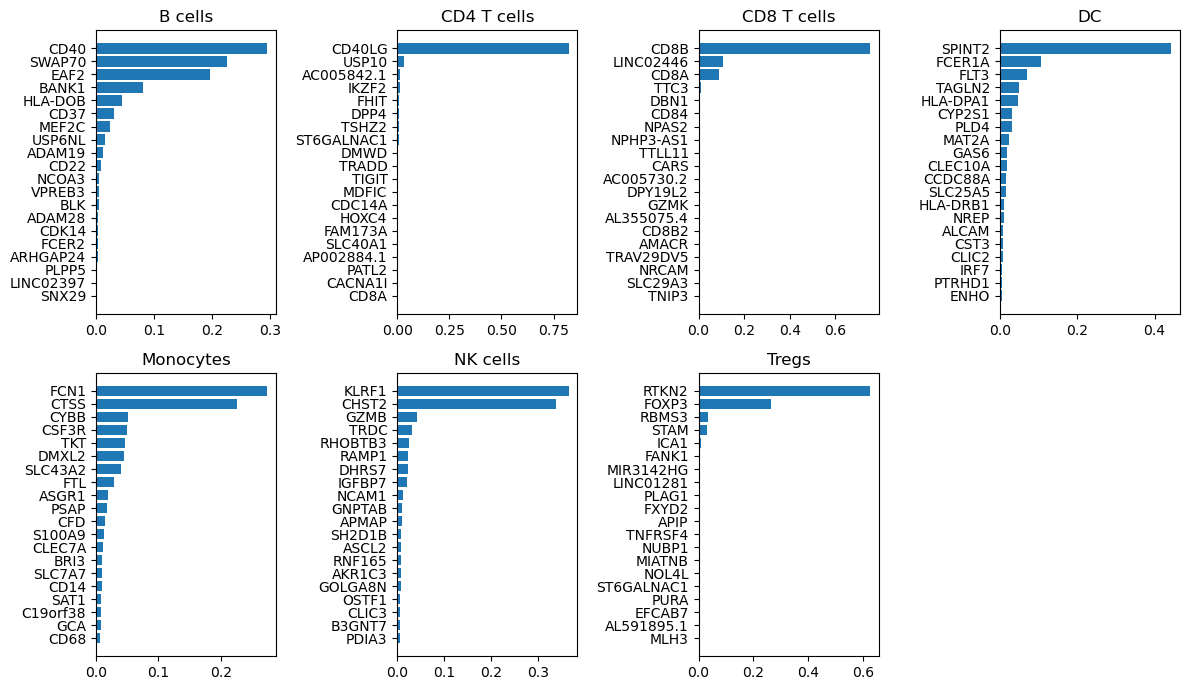

In [14]:
# Plotting feature importances
def plot_feature_importance(model, estimators):

    """
    For GrooD and XGrooD generates barplots of most important features per cell type model
    model: scikit-learn model for GrooD or XGrooD
    estimators: cell types in same order as described in model
    output: target directory for plot
    """
    
    # Get list of cellTypes (same order as in model estimators)
    cellTypes = estimators
    genes = model.estimators_[0].feature_names_in_.tolist()

    # Configure subplots
    n = len(cellTypes)
    rows = math.floor(math.sqrt(n))
    cols = math.ceil(n/rows)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3.5))
    axes = np.array(axes) # axes must be an iterable array

    axes = axes.flatten() # flatten in case of multi-dimensionality

    # iterate over n or cellTypes
    for i in range(0,len(cellTypes)):
        cellType = cellTypes[i]
        feature_importance = model.estimators_[i].feature_importances_
        sorted_idx = np.argsort(feature_importance) # sort highest to lowest importance and get the feature indices
        most_important_features = sorted_idx[-20:] # get 20 most important features
        pos = np.arange(most_important_features.shape[0]) + 0.5
        axes[i].barh(pos, feature_importance[most_important_features], align="center")
        axes[i].set_yticks(pos, np.array(genes)[most_important_features])
        axes[i].set_title(cellType)

    # Hide any unused axes
    for j in range(len(cellTypes), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig('Figure_1B.svg', transparent = True, dpi = 300, format = 'svg')
    plt.show()

estimators = model['metadata']['estimators']
model_file = model['model']

plot_feature_importance(model_file, estimators)

### Figure 1C - Normalization frameworks for Hao pseudobulk framework

In [16]:
rank = pd.read_csv('../grood_runs/GrooD_Hao_pseudobulk_new/intersect_rank/inference/Evaluated_inference_result.csv', index_col=0)
log = pd.read_csv('../grood_runs/GrooD_Hao_pseudobulk_new/intersect_log/inference/Evaluated_inference_result.csv', index_col=0)
cpm = pd.read_csv('../grood_runs/GrooD_Hao_pseudobulk_new/intersect_CPM/inference/Evaluated_inference_result.csv', index_col=0)

In [17]:
CCC_dict = {'CPM':cpm['CCC'].tolist(), 'Log' : log['CCC'].tolist(), 'Rank' : rank['CCC'].tolist()}
df = pd.DataFrame(CCC_dict, index=cpm.index.tolist())
df

,CPM,Log,Rank
B cells,0.997936,0.110254,0.996302
CD4 T cells,0.984774,0.030715,0.984230
CD8 T cells,0.992950,0.086242,0.990504
DC,0.998607,0.071385,0.997135
Monocytes,0.995896,0.061833,0.995887
NK cells,0.996241,0.116182,0.995302
Tregs,0.972701,0.084582,0.980575


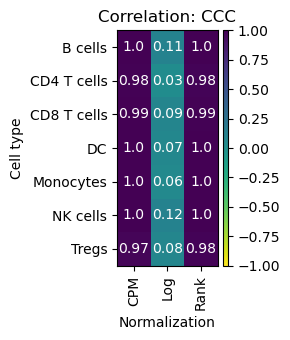

In [18]:
# Changed function for annotated heatmap

def annotated_heatmap(df):

    """"
    Visualizes correlation and error metrics computed with getCorr in heatmaps with fixed scales
    df: output from getCorr
    """

    from mpl_toolkits.axes_grid1 import make_axes_locatable

    fig, ax1 = plt.subplots(1, 1, figsize=(3, 3.5))
    
    im1 = ax1.imshow(df, vmin=-1, vmax=1, cmap='viridis_r')

    for i in range(df.shape[0]):
        for j in range(df.shape[1]): 
            ax1.annotate(str(round(df.iloc[i,j], 2)), xy=(j, i), 
                        ha='center', va='center', color='white')

    ax1.set_title(f'Correlation: CCC')
    ax1.set_xlabel('Normalization')
    ax1.set_ylabel('Cell type')
    ax1.set_yticks(range(df.shape[0]), df.index.tolist())
    ax1.set_xticks(range(df.shape[1]), df.columns.tolist(), rotation = 'vertical')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im1, cax = cax, ax = ax1)

    plt.tight_layout()
    plt.savefig('Figure_1C.svg', transparent = True, dpi = 300, format = 'svg')
    plt.show()

annotated_heatmap(df)

### Figure 1D - Convolution Hao - Finotello

In [19]:
# Get convolution results using Hao and Finotello data account for cell type proportions
eval_res = pd.read_csv('Convolution/Finotello_TPM_data_Hao_2_train_metrics_props.csv', index_col=0)
eval_res = eval_res.loc[eval_res['filter_strategy'] == 'mRNA']
eval_res = eval_res.loc[eval_res['space'] == 'CPM']
eval_res = eval_res.loc[eval_res['metric'].isin(['Pearson', 'CCC', '1-JSD'])]
eval_res.replace({'Pearson' : 'PCC'}, inplace=True)
eval_res.head()

,filter_strategy,space,metric,value
72,mRNA,CPM,1-JSD,0.750915
73,mRNA,CPM,PCC,0.886012
75,mRNA,CPM,CCC,0.849334
80,mRNA,CPM,1-JSD,0.736726
81,mRNA,CPM,PCC,0.886779


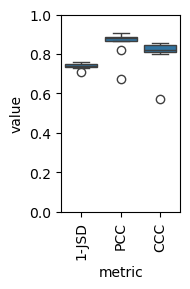

In [21]:
# Plot to visualize distribution of quality metrics

def boxplot_metrics(df):

    """
    Creates boxplot of proportions per cell type across samples in pred
    pred: samples x cell types pandas dataframe
    output: target directory
    """
    plt.figure(figsize=(2,3))
    p = sns.boxplot(data=df, x = "metric", y = "value", hue = "space", legend=False)
    p.set_xticklabels(p.get_xticklabels(), rotation=90)
    p.set_ylim([0,1])
    plt.tight_layout()
    plt.savefig('Figure_1D.svg', transparent = True, dpi = 300, format = 'svg')
    plt.show()

boxplot_metrics(eval_res)

### SI Figure 1B

In [23]:
# Get convolution results using Hao and Finotello data account for cell type proportions
eval_res = pd.read_csv('Convolution/Finotello_TPM_data_Hao_2_train_metrics_props.csv', index_col=0)
# eval_res = eval_res.loc[eval_res['filter_strategy'] == 'mRNA']
eval_res = eval_res.loc[eval_res['space'] == 'CPM']
eval_res = eval_res.loc[eval_res['metric'].isin(['Pearson', 'CCC', '1-JSD'])]
eval_res.replace({'Pearson' : 'PCC'}, inplace=True)
eval_res.replace({'none' : 'all', 'mRNA' : 'coding only'}, inplace=True)
eval_res.head()

,filter_strategy,space,metric,value
0,all,CPM,1-JSD,0.713437
1,all,CPM,PCC,0.556188
3,all,CPM,CCC,0.544391
8,all,CPM,1-JSD,0.704137
9,all,CPM,PCC,0.574603


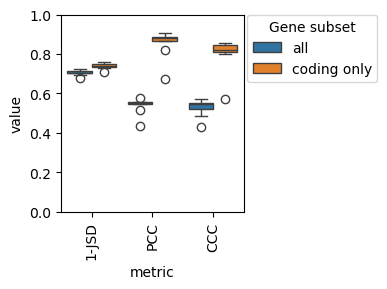

In [24]:
# Plot to visualize distribution of quality metrics

def boxplot_metrics(df):

    """
    Creates boxplot of proportions per cell type across samples in pred
    pred: samples x cell types pandas dataframe
    output: target directory
    """
    plt.figure(figsize=(4,3))
    p = sns.boxplot(data=df, x = "metric", y = "value", hue = "filter_strategy")
    p.set_xticklabels(p.get_xticklabels(), rotation=90)
    p.set_ylim([0,1])
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title = 'Gene subset')
    plt.tight_layout()
    plt.savefig('SI_Figure_1B.svg', transparent = True, dpi = 300, format = 'svg')
    plt.show()

boxplot_metrics(eval_res)

### SI Figure 1C

In [25]:
# Get convolution results using Hao and Finotello data account for cell type proportions
eval_res = pd.read_csv('Convolution/Finotello_TPM_data_Hao_2_train_metrics_no_props.csv', index_col=0)
# eval_res = eval_res.loc[eval_res['filter_strategy'] == 'mRNA']
eval_res = eval_res.loc[eval_res['space'] == 'CPM']
eval_res = eval_res.loc[eval_res['metric'].isin(['Pearson', 'CCC', '1-JSD'])]
eval_res.replace({'Pearson' : 'PCC'}, inplace=True)
eval_res.replace({'none' : 'all', 'mRNA' : 'coding only'}, inplace=True)
eval_res.head()

,filter_strategy,space,metric,value
0,all,CPM,1-JSD,0.718122
1,all,CPM,PCC,0.599222
3,all,CPM,CCC,0.589384
8,all,CPM,1-JSD,0.703220
9,all,CPM,PCC,0.590348


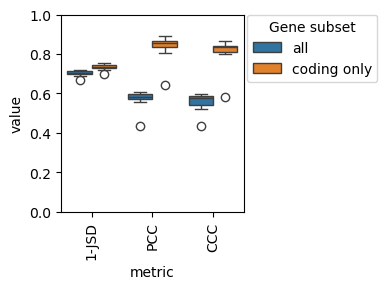

In [27]:
# Plot to visualize distribution of quality metrics

def boxplot_metrics(df):

    """
    Creates boxplot of proportions per cell type across samples in pred
    pred: samples x cell types pandas dataframe
    output: target directory
    """
    plt.figure(figsize=(4,3))
    p = sns.boxplot(data=df, x = "metric", y = "value", hue = "filter_strategy")
    p.set_xticklabels(p.get_xticklabels(), rotation=90)
    p.set_ylim([0,1])
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title = 'Gene subset')
    plt.tight_layout()
    plt.savefig('SI_Figure_1C.svg', transparent = True, dpi = 300, format = 'svg')
    plt.show()

boxplot_metrics(eval_res)

### Figure 1E - Deconvolution Finotello

In [28]:
eval_res = pd.read_csv('../grood_runs/GrooD_Hao_Finotello/mRNA_CPM/inference/Evaluated_inference_result.csv', index_col=0)
eval_res

,PCC,SCC,CCC,RMSE,RD,MAD
B cells,0.537624,0.333333,0.453144,0.012031,-0.090684,0.010596
CD4 T cells,0.860433,0.883333,0.693258,0.054682,0.060489,0.034231
CD8 T cells,0.866525,0.833333,0.578101,0.050567,0.140842,0.038865
DC,-0.777747,-0.666667,-0.158851,0.062761,2.073680,0.047619
Monocytes,0.716624,0.800000,0.498997,0.043091,-0.032161,0.031302
NK cells,0.794031,0.883333,0.558536,0.037634,0.306882,0.031640
Tregs,0.389005,0.476992,0.018353,0.044067,4.540044,0.042271


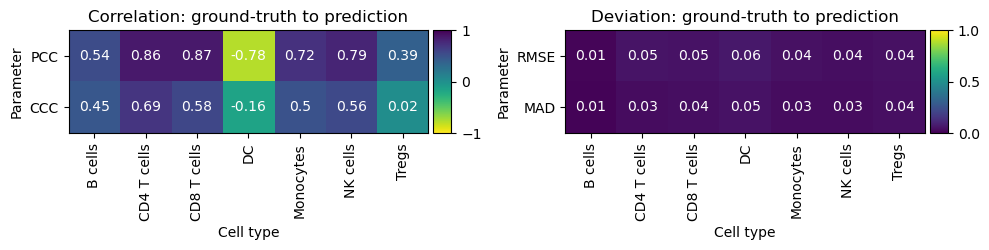

In [29]:
# Changed function for annotated heatmap

def annotated_heatmap(df):

    """"
    Visualizes correlation and error metrics computed with getCorr in heatmaps with fixed scales
    df: output from getCorr
    """

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    df1 = df.loc[['PCC', 'CCC']] # data for SCC, PCC, CCC
    df2 = df.loc[['RMSE', 'MAD']] # data for RMSE and percent deviation

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    im1 = ax1.imshow(df1, vmin=-1, vmax=1, cmap='viridis_r')

    for i in range(df1.shape[0]):
        for j in range(df1.shape[1]): 
            ax1.annotate(str(round(df1.iloc[i,j], 2)), xy=(j, i), 
                        ha='center', va='center', color='white')

    ax1.set_title('Correlation: ground-truth to prediction')
    ax1.set_xlabel('Cell type')
    ax1.set_ylabel('Parameter')
    ax1.set_yticks(range(df1.shape[0]), df1.index.tolist())
    ax1.set_xticks(range(df1.shape[1]), df1.columns.tolist(), rotation = 'vertical')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im1, cax = cax, ax = ax1)

    im2 = ax2.imshow(df2, vmin=0, vmax=1, cmap='viridis')

    for i in range(df2.shape[0]):
        for j in range(df2.shape[1]): 
            ax2.annotate(str(round(df2.iloc[i,j], 2)), xy=(j, i), 
                        ha='center', va='center', color='white')

    ax2.set_title('Deviation: ground-truth to prediction')
    ax2.set_xlabel('Cell type')
    ax2.set_ylabel('Parameter')
    ax2.set_yticks(range(df2.shape[0]), df2.index.tolist())
    ax2.set_xticks(range(df2.shape[1]), df2.columns.tolist(), rotation = 'vertical')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im2, cax = cax, ax = ax2)

    plt.tight_layout()
    plt.savefig('Figure_1E.svg', transparent = True, dpi = 300, format = 'svg')
    plt.show()

annotated_heatmap(eval_res.transpose())

### SI Figure 1D

In [33]:
pred = pd.read_csv('../grood_runs/GrooD_Hao_Finotello/mRNA_CPM/inference/Predicted_cell_type_proportions.csv', index_col=0)
pred.head()

,B cells,CD4 T cells,CD8 T cells,DC,Monocytes,NK cells,Tregs
pbmc_1,0.048676,0.237703,0.238008,0.097510,0.215167,0.104642,0.058294
pbmc_10,0.053030,0.164218,0.240060,0.132355,0.273177,0.096378,0.040783
pbmc_12,0.047564,0.182841,0.295836,0.050068,0.226965,0.159212,0.037514
pbmc_2,0.033124,0.233198,0.247935,0.106293,0.217457,0.107808,0.054185
pbmc_4,0.055231,0.213868,0.272656,0.030464,0.213045,0.144422,0.070314


In [34]:
groundTruth = pd.read_csv('../data/bulk_data/Finotello_2019/final_data/Finotello_FACS_proportions_no_neutrophils_others.csv', index_col=0)
groundTruth.head()

,NK cells,B cells,Tregs,DC,Monocytes,CD8 T cells,CD4 T cells
pbmc_1,0.0675,0.0581,0.0175,0.0160,0.2001,0.1564,0.3796
pbmc_10,0.0718,0.0640,0.0084,0.0227,0.3586,0.1839,0.1786
pbmc_12,0.1409,0.0516,0.0050,0.0426,0.2003,0.2984,0.1533
pbmc_2,0.1128,0.0296,0.0143,0.0234,0.2481,0.1638,0.2552
pbmc_4,0.1154,0.0384,0.0097,0.0357,0.1943,0.2452,0.2247


In [35]:
# Generate QC metrics per cell type and tool

from scipy import stats

def getCorr(df, groundTruth):

    """
    Computes correlation and error metrics for predicitions vs. ground-truth as stored in the MasterTable
    df: predictions
    groundTruth
    """


    rsquared = []
    cccs = []
    rmses = []
    spearmans = []
    percent_dev = []
    absol_dev = []

    # Concordance correlation coefficient
    def ccc(x_data,y_data):
        sxy = np.sum((x_data - np.mean(x_data))*(y_data - np.mean(y_data)))/len(x_data)
        rhoc = 2*sxy / (np.var(x_data) + np.var(y_data) + (np.mean(x_data) - np.mean(y_data))**2)
        return rhoc


    # Pearson Correlation Coefficient
    def r(x_data,y_data):
        ''' Pearson Correlation Coefficient'''
        sxy = np.sum((x_data - np.mean(x_data))*(y_data - np.mean(y_data)))/len(x_data)
        rho = sxy / (np.std(x_data)*np.std(y_data))
        return rho


    # RMSE
    def rmse(x_data,y_data):
        MSE = np.mean(np.square((np.array(x_data)-np.array(y_data))))
        RMSE = np.sqrt(MSE)
        return RMSE

    # Spearmans rank correlation    
    def spearman(x_data, y_data):
        spearmanCorr, _ = stats.spearmanr(np.array(x_data), np.array(y_data))
        return spearmanCorr
    
    # Percent deviation function
    def frac_deviation(x_data, y_data):
        frac_devs = np.mean(np.divide((np.array(y_data) - np.array(x_data)),np.array(x_data), where=(np.array(x_data)!=0)))
        return frac_devs # for sparse data, quite some data points might be excluded due to the removal of 0-divisions from the mean
    
    # Absolute deviation function
    def abs_deviation(x_data, y_data):
        abs_devs = np.mean(abs(np.array(y_data) - np.array(x_data)))
        return abs_devs

    samples = groundTruth.index.tolist()

    for sample in samples:
        
        xdata = df.loc[sample].tolist()
        ydata = groundTruth.loc[sample].tolist()
        b = r(xdata, ydata)
        rsquared.append(b)
        s = spearman(xdata, ydata)
        spearmans.append(s)
        c = ccc(xdata, ydata)
        cccs.append(c)
        a = rmse(xdata, ydata)
        rmses.append(a)
        f = frac_deviation(xdata, ydata)
        percent_dev.append(f)
        g = abs_deviation(xdata, ydata)
        absol_dev.append(g)

    DF = pd.concat([pd.Series(rsquared), pd.Series(spearmans), pd.Series(cccs), pd.Series(rmses), pd.Series(percent_dev), pd.Series(absol_dev)], axis = 1, ignore_index = True)
    DF.columns = ['PCC', 'SCC', 'CCC', 'RMSE', 'RD', 'MAD']
    DF.index = samples

    return DF


    
df = pred
df.sort_index(axis=1, inplace=True)
gt = groundTruth
gt.sort_index(axis=1, inplace=True)

metrics = getCorr(df, gt)
metrics.head()


,PCC,SCC,CCC,RMSE,RD,MAD
pbmc_1,0.831263,0.750000,0.749661,0.072504,-0.216143,0.058206
pbmc_10,0.882077,0.892857,0.826483,0.059107,-0.214903,0.047650
pbmc_12,0.988972,0.964286,0.975778,0.020890,-0.188060,0.017300
pbmc_2,0.890168,0.785714,0.853313,0.049282,-0.240014,0.038296
pbmc_4,0.970622,0.892857,0.946506,0.029398,-0.190557,0.024105


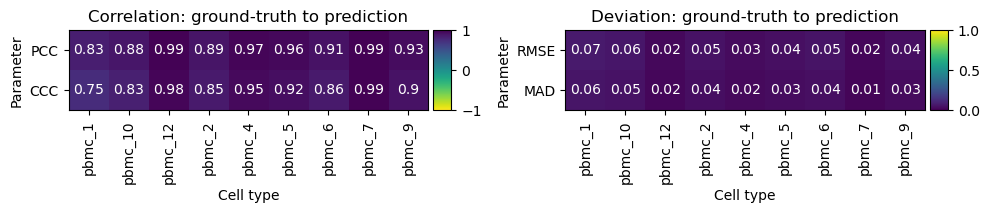

In [36]:
# Changed function for annotated heatmap

def annotated_heatmap(df):

    """"
    Visualizes correlation and error metrics computed with getCorr in heatmaps with fixed scales
    df: output from getCorr
    """

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    df1 = df.loc[['PCC', 'CCC']] # data for SCC, PCC, CCC
    df2 = df.loc[['RMSE', 'MAD']] # data for RMSE and percent deviation

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    im1 = ax1.imshow(df1, vmin=-1, vmax=1, cmap='viridis_r')

    for i in range(df1.shape[0]):
        for j in range(df1.shape[1]): 
            ax1.annotate(str(round(df1.iloc[i,j], 2)), xy=(j, i), 
                        ha='center', va='center', color='white')

    ax1.set_title('Correlation: ground-truth to prediction')
    ax1.set_xlabel('Cell type')
    ax1.set_ylabel('Parameter')
    ax1.set_yticks(range(df1.shape[0]), df1.index.tolist())
    ax1.set_xticks(range(df1.shape[1]), df1.columns.tolist(), rotation = 'vertical')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im1, cax = cax, ax = ax1)

    im2 = ax2.imshow(df2, vmin=0, vmax=1, cmap='viridis')

    for i in range(df2.shape[0]):
        for j in range(df2.shape[1]): 
            ax2.annotate(str(round(df2.iloc[i,j], 2)), xy=(j, i), 
                        ha='center', va='center', color='white')

    ax2.set_title('Deviation: ground-truth to prediction')
    ax2.set_xlabel('Cell type')
    ax2.set_ylabel('Parameter')
    ax2.set_yticks(range(df2.shape[0]), df2.index.tolist())
    ax2.set_xticks(range(df2.shape[1]), df2.columns.tolist(), rotation = 'vertical')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im2, cax = cax, ax = ax2)

    plt.tight_layout()
    plt.savefig('SI_Figure_1D.svg', transparent = True, dpi = 300, format = 'svg')
    plt.show()

annotated_heatmap(metrics.transpose())